# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.207692,True,4.164777
1,-0.459890,False,-0.604023
2,-0.076955,False,-0.324600
3,0.426903,False,-0.376944
4,1.736633,False,0.020950
...,...,...,...
995,-0.586682,False,-2.282914
996,-1.638754,False,0.066172
997,0.823974,True,5.351142
998,0.694116,False,0.178229


<AxesSubplot:xlabel='v0'>

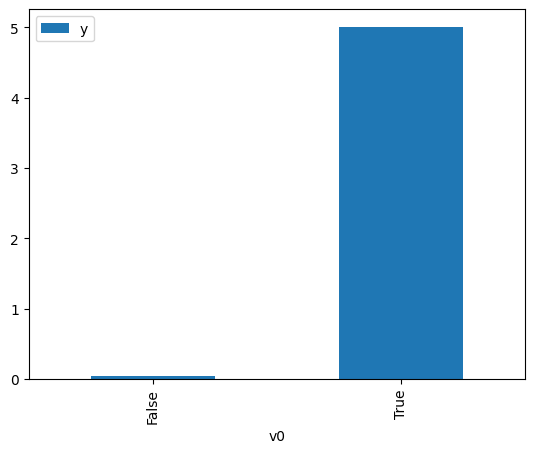

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

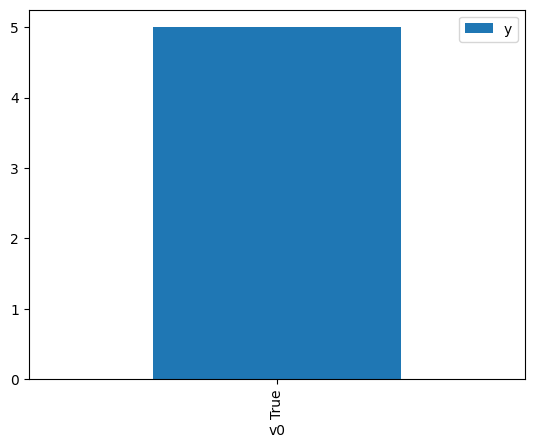

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.655357,False,-1.064664,0.530942,1.883444
1,-1.100907,False,-1.151810,0.524858,1.905277
2,0.252762,False,-0.419531,0.519554,1.924728
3,1.862745,False,0.069829,0.513240,1.948408
4,1.863891,False,0.945203,0.513235,1.948425
...,...,...,...,...,...
995,-0.910896,False,0.785751,0.524114,1.907982
996,-1.480212,False,-0.575497,0.526344,1.899900
997,-0.068917,False,0.441566,0.520815,1.920068
998,-0.586682,False,-2.282914,0.522844,1.912617


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.291373,True,5.897116,0.478313,2.090680
1,-0.387313,True,4.897076,0.477937,2.092324
2,-1.206813,True,3.962397,0.474727,2.106474
3,-1.640396,True,4.221348,0.473029,2.114034
4,0.062713,True,5.061817,0.479701,2.084631
...,...,...,...,...,...
995,1.982424,True,5.340725,0.487230,2.052419
996,-0.930301,True,4.166256,0.475810,2.101679
997,-0.964810,True,4.947903,0.475675,2.102276
998,2.238575,True,5.692573,0.488235,2.048193


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              6282.
Date:                Fri, 02 Sep 2022   Prob (F-statistic):                        0.00
Time:                        09:09:05   Log-Likelihood:                         -1402.6
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2819.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3705      0.031     11.859      0.000       0.309       0.432
x2             4.9557      0.045    109.685      0.000       4.867       5.044
==============================================================================
Omnibus:                        3.315   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                3.708
Skew:                           0.018   Prob(JB):                        0.157
Kurtosis:                       3.296   Cond. No.                         1.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""